In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Load V1 receptive fields from Marius

In [2]:
from data_fns import load_V1_Marius
from scipy import ndimage

rf_data, snr = load_V1_Marius(data_dir='data/V1_data_Marius/', normalized=True, centered=True)

### Select neurons with SNR greater than 0.4

/home/bpandey/anaconda3/lib/python3.8/site-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


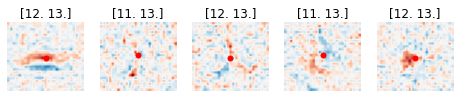

In [3]:
rf = rf_data[:, snr > 0.4, :]
num_trials, num_cells, dim = rf.shape

fig = plt.figure(figsize=(8, 8))
for i in range(5):
    ax = fig.add_subplot(1, 5, i + 1)
    idx = np.random.randint((num_trials, num_cells))
    cell_rf = rf[idx[0], idx[1]].reshape(24, 27)
    com = np.round(ndimage.measurements.center_of_mass(np.abs(cell_rf)))
    plt.title(com)    
    plt.imshow(cell_rf, cmap='RdBu')
    plt.plot(com[1], com[0], 'ro', markersize=5)
    plt.clim([-5, 5])
    plt.axis('off')

## Analysis on the average of receptive fields of all 3 repeat experiments 

### Fit optimal hyperparams to the data

In [34]:
from estimator import  V1_inspired_kernel_matrix
import numpy.linalg as la
from scipy.optimize import minimize

avg_rf = np.mean(rf, axis=0)
dim = (27, 24)

# compute data covariance
cov_data = avg_rf.T @ avg_rf
cov_data *= cov_data.shape[1] / np.trace(cov_data)

# find params that minimize frobenius norm difference between data and covariance model
def frob_norm_diff(x):
    cov_model = V1_inspired_kernel_matrix(N=dim, s=x[0], f=x[1], center=(12, 13), scale=1)
    return la.norm(cov_data - cov_model)

x0 = [11, 1]
minimize_diff = minimize(frob_norm_diff, x0, method='BFGS', tol=1e-4)
s_min, f_min = minimize_diff.x
print('Optimal params: s=%0.2f, f=%0.2f' % (s_min, f_min))

Optimal params: s=5.54, f=1.16


### generate model covariance w/ analytical model and covariance matrix from sampled 250 neurons 

(-0.5, 647.5, 647.5, -0.5)

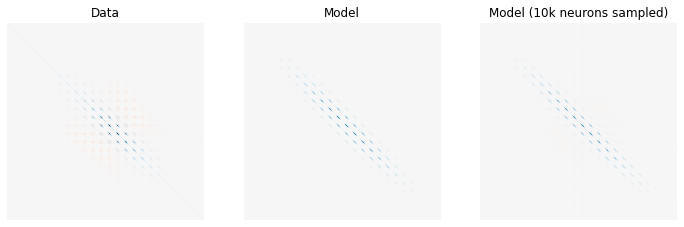

In [35]:
from estimator import V1_inspired_weights_same_center

# model
cov_model = V1_inspired_kernel_matrix(dim, s=s_min, f=f_min, center=(12, 13), scale=1)

# cov from sampled 1000 neurons
W = V1_inspired_weights_same_center(num_cells, dim, s=s_min, f=f_min, center=(12, 13), scale=1)
W = (W - np.mean(W, axis=1).reshape(-1, 1)) / np.std(W, axis=1).reshape(-1, 1)
cov_sampled_neurons = W.T @ W
cov_sampled_neurons *= cov_data.shape[0] / np.trace(cov_sampled_neurons).reshape(-1, 1)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(131)
plt.title('Data')
plt.imshow(cov_data, cmap='RdBu')
plt.clim(-5, 5)
plt.axis('off')
# plt.xlim(200, 500)
# plt.ylim(200, 500)

ax = fig.add_subplot(132)
plt.title('Model')
plt.imshow(cov_model, cmap='RdBu')
plt.clim(-5, 5)
plt.axis('off')
# plt.xlim(200, 500)
# plt.ylim(200, 500)

ax = fig.add_subplot(133)
plt.title('Model (10k neurons sampled)')
plt.imshow(cov_sampled_neurons, cmap='RdBu')
plt.clim(-5, 5)
plt.axis('off')
# plt.xlim(200, 500)
# plt.ylim(200, 500)
# plt.savefig('results/V1_data/cov_mat_fitted_Marius_trial_avg.pdf')

### plot a few receptive fields from the data and the model

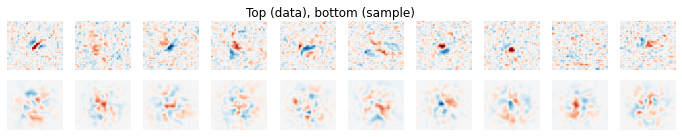

In [36]:
fig = plt.figure(figsize=(12, 2))
plt.suptitle('Top (data), bottom (sample)')
for i in range(10):
    idx = np.random.randint(num_cells)
    ax = fig.add_subplot(2, 10, i + 1)
    cell_rf = rf[0, idx].reshape(24, 27) 
    plt.imshow(cell_rf, cmap='RdBu')
    plt.clim([-5, 5])
    plt.axis('off')
    
    
    ax = fig.add_subplot(2, 10, 10 + i + 1)
    cell_rf = W[idx].reshape(24, 27) 
    plt.imshow(cell_rf, cmap='RdBu')
    plt.clim([-8, 8])
    plt.axis('off')
#     plt.savefig('results/V1_data/rfs_Marius_data.pdf')

### Generate covariance matrices with fine discretization for spectral analysis

In [6]:
# plot the V1 covariance matrix with finer mesh
from scipy.spatial.distance import pdist, squareform
import numpy.linalg as la 

dim = (24, 27)
center = [12, 13]
s, f, scale = s_min, f_min, 1

x = np.arange(0, dim[0], 0.5)
y = np.arange(0, dim[1], 0.5)
yy, xx = np.meshgrid(y, x)
grid = np.column_stack((xx.flatten(), yy.flatten()))

a = squareform(pdist(grid, 'sqeuclidean'))
b = la.norm(grid - center, axis=1) ** 2
c = b.reshape(-1, 1)
cov_model_fine = np.exp(-a / (2 * f ** 2)) * np.exp(-b / (2 * s ** 2)) * np.exp(-c / (2 * s ** 2))
cov_model_fine += 1e-5 * np.eye(len(cov_model_fine))
cov_model_fine *= (scale * cov_model_fine.shape[0] / np.trace(cov_model_fine))

# generate weights
L = la.cholesky(cov_model_fine)
W_fine = np.dot(L, np.random.randn(cov_model_fine.shape[0], num_cells)).T
W_fine = (W_fine - np.mean(W_fine, axis=1).reshape(-1, 1)) / np.std(W_fine, axis=1).reshape(-1, 1)
cov_sampled_neurons_fine = W_fine.T @ W_fine
cov_sampled_neurons_fine *= (cov_sampled_neurons_fine.shape[0] / np.trace(cov_sampled_neurons_fine))

### Generate eigenvalues and eigenvectors

In [7]:
# generate eigenfunctions and eigenvalues from the covariance matrices
eval_data, evec_data = la.eigh(cov_data)
eval_model, evec_model = la.eigh(cov_model_fine)
eval_sampled_neurons, evec_sampled_neurons = la.eigh(cov_sampled_neurons_fine)

### define the analytical form of the eigenfunctions and eigenvalues

In [8]:
from scipy.special import eval_hermitenorm
def phi(x, s, f, k):
    ''' Orthonormal eigenfunctions of the V1 kernel in 1d'''
    alpha, beta = 1 / (2 * f ** 2), 1 / (2 * s ** 2)
    D = np.sqrt(beta ** 2 + 2 * alpha * beta)
    C = np.sqrt(2 * D)
    normalization_fac = 2 ** k * np.math.factorial(k) * np.sqrt(np.pi) / C
    return np.exp(- D * x ** 2) * eval_hermitenorm(k, C * x)

def lamda(s, f, k):
    ''' Eigenvalues of the V1 kernel in 1d '''
    alpha, beta = 1 / (2 * f ** 2), 1 / (2 * s ** 2)
    D = np.sqrt(beta ** 2 + 2 * alpha * beta)
    C = np.sqrt(2 * D)
    X = alpha + beta + D
    return np.sqrt(np.pi / X) * ( 1 - C ** 2 / X) ** (k / 2)


# generate all the eigenfunctions 
x = np.arange(-12, 12, 0.1)
y = np.arange(-13, 13, 0.1)
yy, xx = np.meshgrid(y, x)

evec_anal = np.empty((0, len(x) * len(y)))
eval_anal = np.empty((0, ))
for k1 in range(15):
    for k2 in range(15):
        eigvec = phi(yy, s_min, f_min, k1) * phi(xx, s_min, f_min, k2)
        eigvec = eigvec.reshape(1, -1)
        eigval = lamda(s_min, f_min, k1) * lamda(s_min, f_min, k2)
        
        evec_anal = np.append(evec_anal, eigvec.reshape(1, -1), axis=0)
        eval_anal = np.append(eval_anal, eigval)
        
# sort in descending order
idx = np.argsort(-eval_anal)
evec_anal = evec_anal[idx]
eval_anal = eval_anal[idx[::-1]]

### Plot eigenvalues from all 4 (data, model, sampled neurons, analytical)

Data: 100 evecs explain 0.59 variance
Model: 100 evecs explain 0.92 variance
Sampled neurons: 100 evecs explain 0.92 variance


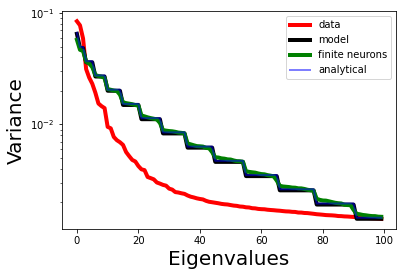

In [9]:
# eigevalues
eval_data /= np.sum(eval_data)
eval_model /= np.sum(eval_model)
eval_sampled_neurons /= np.sum(eval_sampled_neurons)
eval_anal /= np.sum(eval_anal)

t = 100
fig = plt.figure()
plt.semilogy(np.flip(eval_data)[:t], lw=4, c='r', label='data')
plt.semilogy(np.flip(eval_model)[:t], lw=4, c='k', label='model')
plt.semilogy(np.flip(eval_sampled_neurons)[:t], lw=4, c='g', label='finite neurons')
plt.semilogy(np.flip(eval_anal)[:t], lw=2, c='b', alpha=0.5, label='analytical')
plt.legend()
# plt.ylim(1e-4, 1e-1)
plt.xlabel('Eigenvalues', fontsize=20)
plt.ylabel('Variance', fontsize=20)

print('Data: %d evecs explain %0.2f variance' % (t, np.sum(eval_data[-t:])))
print('Model: %d evecs explain %0.2f variance' % (t, np.sum(eval_model[-t:])))
print('Sampled neurons: %d evecs explain %0.2f variance' % (t, np.sum(eval_sampled_neurons[-t:])))
# plt.savefig('results/V1_data/cov_mat_eigvals_Marius_trial_avg.pdf')

### Plot eigenfunctions from all 4 (data, model, sampled neurons, analytical)

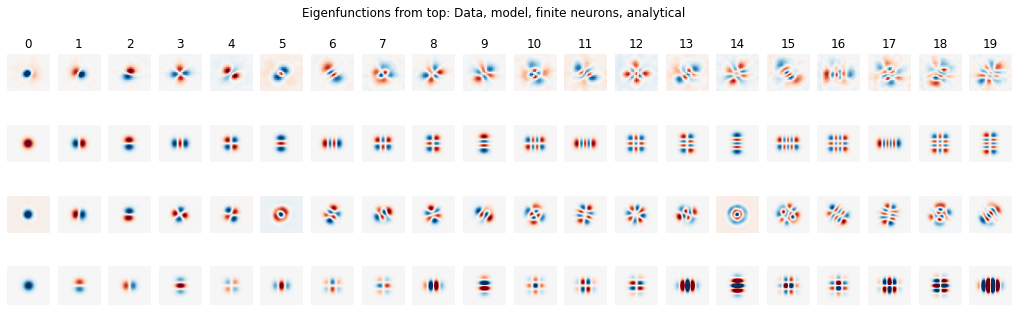

In [10]:
# plot eigenfunctions from all 4 (data, model, finite sample, analytical)
fig = plt.figure(figsize=(18, 5))
plt.suptitle('Eigenfunctions from top: Data, model, finite neurons, analytical')
for i in range(20):
    ax = fig.add_subplot(4, 20, i + 1)
    plt.imshow(evec_data[:, -i-1].reshape(24, 27), cmap='RdBu')
    plt.title(i)
    plt.clim(-0.2, 0.2)
    plt.axis('off')
    
    ax = fig.add_subplot(4, 20, 20 + i + 1)
    plt.imshow(evec_model[:, -i-1].reshape(48, 54), cmap='RdBu')
    plt.clim(-0.1, 0.1)
    plt.axis('off')
    
    ax = fig.add_subplot(4, 20, 40 + i + 1)
    plt.imshow(evec_sampled_neurons[:, -i - 1].reshape(48, 54), cmap='RdBu')
    plt.clim(-0.1, 0.1)
    plt.axis('off')
    
    ax = fig.add_subplot(4, 20, 60 + i + 1)
    plt.imshow(evec_anal[i].reshape(240, 260), cmap='RdBu')
    plt.clim(-0.8, 0.8)
    plt.axis('off')
#     plt.savefig('results/V1_data/cov_mat_eigvecs_Marius_trial_avg.pdf')

### check if the data is normally distributed 

In [ ]:
import numpy as np

# data = np.random.normal(-1, 1, size=(100, 600))
data = avg_rf.copy()

from scipy.stats import shapiro
print('Shapiro test')
stat, p = shapiro(data)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')
    
import pingouin as pg
pg.multivariate_normality(data, alpha=0.5)

## Analysis on the receptive fields of each trial

In [ ]:
from estimator import  V1_inspired_kernel_matrix
import numpy.linalg as la
from scipy.optimize import minimize

trial = 2
trial_rf = rf[trial, :, :]
dim = (27, 24)

# compute data covariance
cov_data = trial_rf.T @ avg_rf
cov_data *= cov_data.shape[1] / np.trace(cov_data)

# find params that minimize frobenius norm difference between data and covariance model
def frob_norm_diff(x):
    cov_model = V1_inspired_kernel_matrix(N=dim, s=x[0], f=x[1], center=(12, 13), scale=1)
    return la.norm(cov_data - cov_model)

x0 = [1, 1]
minimize_diff = minimize(frob_norm_diff, x0, method='BFGS', tol=1e-4)
s_min, f_min = minimize_diff.x
print('Optimal params: s=%0.2f, f=%0.2f' % (s_min, f_min))

### generate model covariance w/ analytical model and covariance matrix from sampled 250 neurons 

In [ ]:
from estimator import V1_inspired_weights_same_center

# model
cov_model = V1_inspired_kernel_matrix(dim, s=s_min, f=f_min, center=(12, 13), scale=1)

# cov from sampled 250 neurons
W = V1_inspired_weights_same_center(num_cells, dim, s=s_min, f=f_min, center=(12, 13), scale=1)
W = (W - np.mean(W, axis=1).reshape(-1, 1)) / np.std(W, axis=1).reshape(-1, 1)
cov_sampled_neurons = W.T @ W
cov_sampled_neurons *= cov_data.shape[0] / np.trace(cov_sampled_neurons).reshape(-1, 1)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(131)
plt.title('Data')
plt.imshow(cov_data, cmap='RdBu')
plt.clim(-5, 5)
plt.axis('off')
plt.xlim(200, 500)
plt.ylim(200, 500)

ax = fig.add_subplot(132)
plt.title('Model')
plt.imshow(cov_model, cmap='RdBu')
plt.clim(-5, 5)
plt.axis('off')
plt.xlim(200, 500)
plt.ylim(200, 500)

ax = fig.add_subplot(133)
plt.title('Model (250 neurons sampled)')
plt.imshow(cov_sampled_neurons, cmap='RdBu')
plt.clim(-5, 5)
plt.axis('off')
plt.xlim(200, 500)
plt.ylim(200, 500)
plt.savefig('results/V1_data/cov_mat_fitted_Marius_trial_%d.pdf' % trial)

### Generate covariance matrices with fine discretization for spectral analysis

In [ ]:
# plot the V1 covariance matrix with finer mesh
from scipy.spatial.distance import pdist, squareform
import numpy.linalg as la 

dim = (24, 27)
center = [12, 13]
s, f, scale = s_min, f_min, 1

x = np.arange(0, dim[0], 0.5)
y = np.arange(0, dim[1], 0.5)
yy, xx = np.meshgrid(y, x)
grid = np.column_stack((xx.flatten(), yy.flatten()))

a = squareform(pdist(grid, 'sqeuclidean'))
b = la.norm(grid - center, axis=1) ** 2
c = b.reshape(-1, 1)
cov_model_fine = np.exp(-a / (2 * f ** 2)) * np.exp(-b / (2 * s ** 2)) * np.exp(-c / (2 * s ** 2))
cov_model_fine += 1e-5 * np.eye(len(cov_model_fine))
cov_model_fine *= (scale * cov_model_fine.shape[0] / np.trace(cov_model_fine))

# generate weights
L = la.cholesky(cov_model_fine)
W_fine = np.dot(L, np.random.randn(cov_model_fine.shape[0], num_cells)).T
W_fine = (W_fine - np.mean(W_fine, axis=1).reshape(-1, 1)) / np.std(W_fine, axis=1).reshape(-1, 1)
cov_sampled_neurons_fine = W_fine.T @ W_fine
cov_sampled_neurons_fine *= (cov_sampled_neurons_fine.shape[0] / np.trace(cov_sampled_neurons_fine))

### Generate eigenvalues and eigenvectors

In [ ]:
# generate eigenfunctions and eigenvalues from the covariance matrices
eval_data, evec_data = la.eigh(cov_data)
eval_model, evec_model = la.eigh(cov_model_fine)
eval_sampled_neurons, evec_sampled_neurons = la.eigh(cov_sampled_neurons_fine)

### define the analytical form of the eigenfunctions and eigenvalues

In [ ]:
from scipy.special import eval_hermitenorm
def phi(x, s, f, k):
    ''' Orthonormal eigenfunctions of the V1 kernel in 1d'''
    alpha, beta = 1 / (2 * f ** 2), 1 / (2 * s ** 2)
    D = np.sqrt(beta ** 2 + 2 * alpha * beta)
    C = np.sqrt(2 * D)
    normalization_fac = 2 ** k * np.math.factorial(k) * np.sqrt(np.pi) / C
    return np.exp(- D * x ** 2) * eval_hermitenorm(k, C * x)

def lamda(s, f, k):
    ''' Eigenvalues of the V1 kernel in 1d '''
    alpha, beta = 1 / (2 * f ** 2), 1 / (2 * s ** 2)
    D = np.sqrt(beta ** 2 + 2 * alpha * beta)
    C = np.sqrt(2 * D)
    X = alpha + beta + D
    return np.sqrt(np.pi / X) * ( 1 - C ** 2 / X) ** (k / 2)


# generate all the eigenfunctions 
x = np.arange(-12, 12, 0.1)
y = np.arange(-13, 13, 0.1)
yy, xx = np.meshgrid(y, x)

evec_anal = np.empty((0, len(x) * len(y)))
eval_anal = np.empty((0, ))
for k1 in range(15):
    for k2 in range(15):
        eigvec = phi(yy, s_min, f_min, k1) * phi(xx, s_min, f_min, k2)
        eigvec = eigvec.reshape(1, -1)
        eigval = lamda(s_min, f_min, k1) * lamda(s_min, f_min, k2)
        
        evec_anal = np.append(evec_anal, eigvec.reshape(1, -1), axis=0)
        eval_anal = np.append(eval_anal, eigval)
        
# sort in descending order
idx = np.argsort(-eval_anal)
evec_anal = evec_anal[idx]
eval_anal = eval_anal[idx[::-1]]

### Plot eigenvalues from all 4 (data, model, sampled neurons, analytical)

In [ ]:
# eigevalues
eval_data /= np.sum(eval_data)
eval_model /= np.sum(eval_model)
eval_sampled_neurons /= np.sum(eval_sampled_neurons)
eval_anal /= np.sum(eval_anal)

t = 100
fig = plt.figure()
plt.semilogy(np.flip(eval_data)[:t], lw=4, c='r', label='data')
plt.semilogy(np.flip(eval_model)[:t], lw=4, c='k', label='model')
plt.semilogy(np.flip(eval_sampled_neurons)[:t], lw=4, c='g', label='finite neurons')
plt.semilogy(np.flip(eval_anal)[:t], lw=2, c='b', alpha=0.5, label='analytical')
plt.legend()
# plt.ylim(1e-4, 1e-1)
plt.xlabel('Eigenvalues', fontsize=20)
plt.ylabel('Variance', fontsize=20)

print('Data: %d evecs explain %0.2f variance' % (t, np.sum(eval_data[-t:])))
print('Model: %d evecs explain %0.2f variance' % (t, np.sum(eval_model[-t:])))
print('Sampled neurons: %d evecs explain %0.2f variance' % (t, np.sum(eval_sampled_neurons[-t:])))
plt.savefig('results/V1_data/cov_mat_eigvals_Marius_trial_%d.pdf' % trial)

### Plot eigenfunctions from all 4 (data, model, sampled neurons, analytical)

In [ ]:
# plot eigenfunctions from all 4 (data, model, finite sample, analytical)
fig = plt.figure(figsize=(18, 5))
plt.suptitle('Eigenfunctions from top: Data, model, finite neurons, analytical')
for i in range(20):
    ax = fig.add_subplot(4, 20, i + 1)
    plt.imshow(evec_data[:, -i-1].reshape(24, 27), cmap='RdBu')
    plt.title(i)
    plt.clim(-0.2, 0.2)
    plt.axis('off')
    
    ax = fig.add_subplot(4, 20, 20 + i + 1)
    plt.imshow(evec_model[:, -i-1].reshape(48, 54), cmap='RdBu')
    plt.clim(-0.1, 0.1)
    plt.axis('off')
    
    ax = fig.add_subplot(4, 20, 40 + i + 1)
    plt.imshow(evec_sampled_neurons[:, -i - 1].reshape(48, 54), cmap='RdBu')
    plt.clim(-0.1, 0.1)
    plt.axis('off')
    
    ax = fig.add_subplot(4, 20, 60 + i + 1)
    plt.imshow(evec_anal[i].reshape(240, 260), cmap='RdBu')
    plt.clim(-0.1, 0.1)
    plt.axis('off')
    
plt.savefig('results/V1_data/cov_mat_eigvecs_Marius_trial_%d.pdf' % trial)

In [ ]:
trial